<a href="https://colab.research.google.com/github/jorgeerrz/mistaken_mice/blob/master/mistaken_mice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mistaken Mice notebook

2020 NMA academy project, mistaken mice group, pod 173 antique cicada

# Import packages and functions

In [7]:
# to import the functions we wrote, clone the git repo
# !git clone https://github.com/jorgeerrz/mistaken_mice.git
# %cd mistaken_mice
#alternatively, run the notebook locally, then just comment the lines above

# from filter import *
# from summarise_dataset import *
# from PCA_fun import neurons_PCA
# from GLM import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from filter import *
from summarise_dataset import *
from PCA_fun import neurons_PCA
from GLM import *
from rebin import *
from model_tester import test_model
from scipy import stats

# Loading of Steinmetz data

In [9]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)


In [57]:
# skip if you already downloaded the data
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)
        
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]


def find_region(area):
    locs = [area in bg for bg in brain_groups]
    if np.sum(locs) > 0:
        return regions[np.where(locs)[0][0]]
    else:
        return 'other'
    
    
find_region('fkdsfjkasdf')

'other'

In [11]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


# Filter, PCA, and Model one session

In [12]:
filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
rebinned = rebin(filtered, 50, 250, 2)
rebinned['spks'].shape, filtered['spks'].shape

NameError: name 'session' is not defined

In [ ]:
probs[:,1]

In [ ]:
from sklearn.model_selection import *

session = 0
brain_areas = ["MOs"]


filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
#filtered = rebin(filtered, 50, 250, 2)
dat = neurons_PCA(filtered,0.9,50,250,toplot=False)
#dat['PCs'] = dat['PCs'][0:dat['PCrange'],:]

lambda_L2 = 1
penalty = "l2"
l1args = {}
left_bias = np.mean((filtered['chcs'])==1)
choice_bias = [left_bias if left_bias > .5 else (1.0-left_bias)]
w = {-1:left_bias, 1:(1-left_bias)}



logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args,class_weight=w).fit(dat['PCs'].T, filtered['chcs'])
splitter = LeaveOneOut()
splits = splitter.split(dat['PCs'].T)
accuracies=[]
predictions = []
probs = []
#Manual K-1 corss validation, saving predicitons:
for fit_trials,test_trial in splits:
    logreg.fit((dat['PCs'][:,fit_trials]).T, dat['chcs'][fit_trials])
    prediction = logreg.predict(dat['PCs'][:,test_trial].T)[0]
    prob = logreg.predict_proba(dat['PCs'][:,test_trial].T)[0]
    actual = dat['chcs'][test_trial][0]
    accuracy = int(actual == prediction)
    predictions.append(prediction)
    accuracies.append(accuracy)
    probs.append(prob)

probs = np.array(probs)
mprobs = [max(prob) for prob in probs]

print('Number of PCs: '+str(dat['PCrange']))

print('Accuracies: '+str(accuracies))
print('Mean Accuracy: '+str(np.mean(accuracies)))
print('Predictions: '+ str(predictions))
print('Actual: '+ str(filtered['chcs']))
print('Probs: '+ str(probs))
actual_choice_probs = [(prob[0] if choice==-1 else prob[1]) for prob,choice in zip(probs,filtered['chcs'])]
print('Brier score: '+str(np.sum((probs[:,1] - (filtered['chcs'] + 1)/2)**2)))
print('Weight right: '+str(w[-1])+' weight left: '+str(w[1]))
print('Percent Left: ' +str(np.mean((filtered['chcs'])==1)))
print('Percent Right: ' +str(np.mean((filtered['chcs'])==-1)))

plt.plot(predictions,linewidth=0,marker='o')
plt.plot(filtered['chcs'],linewidth=0,marker='x')



# one session, get PCA and model weights together

In [ ]:
plot_session(alldat,session,unfair_only=True,chosey_only=True, nonzero_only=True, select_areas = allb)

In [ ]:
# help(LogisticRegression)

done


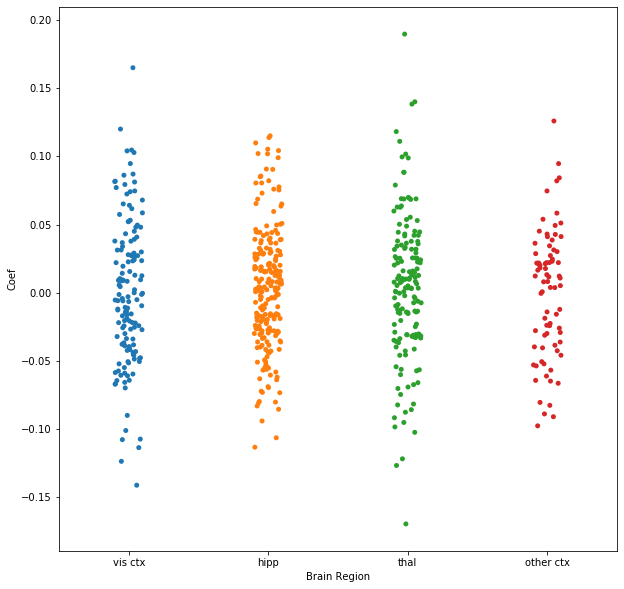

In [263]:
import pandas as pd
import seaborn as sns

allb = ['ACA','ACB','APN', 'AUD', 'BLA', 'BMA', 'CA', 'CA1', 'CA2', 'CA3', 'CL', 'COA',
 'CP','DG','DP','EP','EPd','GPe','IC' ,'ILA', 'LD', 'LGd' ,'LH', 'LP', 'LS',
 'LSc','LSr','MB','MD','MEA','MG','MOp','MOs','MRN','MS','NB','OLF','ORB',
 'ORBm','OT','PAG','PIR','PL','PO','POL','POST','PT','RN','RSP','RT',
 'SCig','SCm','SCs','SCsg','SI','SNr','SPF','SSp','SSs','SUB','TH','TT',
 'VAL','VISa','VISam','VISl','VISp','VISpm','VISrl','VPL','VPM','ZI']

def explore_weights(session=11,reg='none',C=1,solver='lbfgs',unfair_only=True,chosey_only=True, nonzero_only=True,brain_area=allb,ax=plt):
    
    filtered = filter_spikes(alldat,session,unfair_only=unfair_only,chosey_only=chosey_only,nonzero_only=nonzero_only,brain_area=brain_area)
    
    dat = neurons_PCA(filtered,0.9,0,250)
    lambda_L2 = C
    penalty = reg
    solver = solver
    l1args = {}
    left_bias = np.mean((filtered['chcs'])==1)
    choice_bias = [left_bias if left_bias > .5 else (1.0-left_bias)]
    w = {-1:left_bias, 1:(1-left_bias)}
    #l1args = {'solver':"saga", 'max_iter':5000}
    logreg = LogisticRegression(penalty = penalty, C = lambda_L2,solver=solver, **l1args)
    logreg.fit((dat['PCs']).T, dat['chcs'])

    pclogreg_coeffs = logreg.coef_ @ dat['weights']
    #print(np.shape(pclogreg_coeffs))

    #brain_coeffs = []
    #for i,coef in enumerate(pclogreg_coeffs[0,:]):
    #     plt.plot([i],[coef], 'o', label=filtered['brain_area'][i])

    pclogreg_coeffs_f = pclogreg_coeffs[0,:]

    
    brain_regions = [find_region(area) for area in filtered['brain_area']]

    data_summary = pd.DataFrame({'Neuron':np.arange(len(pclogreg_coeffs_f)),'Coef':pclogreg_coeffs_f,'Brain Area':filtered['brain_area'],'Brain Region':brain_regions})        
    # plt.plot(pclogreg_coeffs[0,:], 'o', label=filtered['brain_area'])

    pc_summary = pd.DataFrame({'PC':np.arange(dat['weights'].shape[0]),'Coef':logreg.coef_[0,:]})        

   # 
   # sns.barplot(x='Brain Area',y='Coef',estimator=(lambda x: np.mean(np.abs(x))),data=data_summary,ci="sd",ax=ax,zorder=2)
   # sns.stripplot(y='Coef',data=pc_summary,ax=axe)
    data_summary.groupby('Brain Area').agg(lambda x: np.sum((np.abs(x)>(np.std(x)+np.mean(x)))))
    data_summary[data_summary['Brain Area']=='MRN'].sort_values('Coef')
    
    return data_summary

    #print(np.sum(logreg.coef_[0,:]==0))
    #print(np.sum(pclogreg_coeffs_f==0))


fig,axe = plt.subplots(1, 1, figsize=(10, 10))
sample1 = explore_weights(session=11,reg='l2',C=all_trial_max,solver='lbfgs',unfair_only=False,chosey_only=True, nonzero_only=False,ax=axe)

sns.stripplot(x='Brain Region',y='Coef',data=sample1,ax=axe,zorder=1)
#for ax in axes:
#        ax.set_ylim(-.5,.5)



#fig,axes = plt.subplots(10, 2, figsize=(10, 10))

#df = pd.DataFrame([], columns=[])


print('done')



In [269]:
onesum=None
df_all = pd.DataFrame([], columns=[])
for session in range(37):
    out = explore_weights(session=session,ax=ax,reg='l2',C=all_trial_max,unfair_only=False,chosey_only=True, nonzero_only=False,brain_area=allb)
    onesum = out.copy()
    onesum['Session'] = [session]*len(onesum)
    df_all = df_all.append(onesum,ignore_index=True)
    


In [270]:
onesum=None
df_unfair = pd.DataFrame([], columns=[])
for session in range(37):
    out = explore_weights(session=session,ax=ax,reg='l2',C=unfair_trial_max,unfair_only=True,chosey_only=True, nonzero_only=True,brain_area=allb)
    onesum = out.copy()
    onesum['Session'] = [session]*len(onesum)
    df_unfair = df_unfair.append(onesum,ignore_index=True)
    
print('done')

done


In [267]:
df_all['Brain Region'].unique()

array(['other ctx', 'basal ganglia', 'vis ctx', 'hipp'], dtype=object)

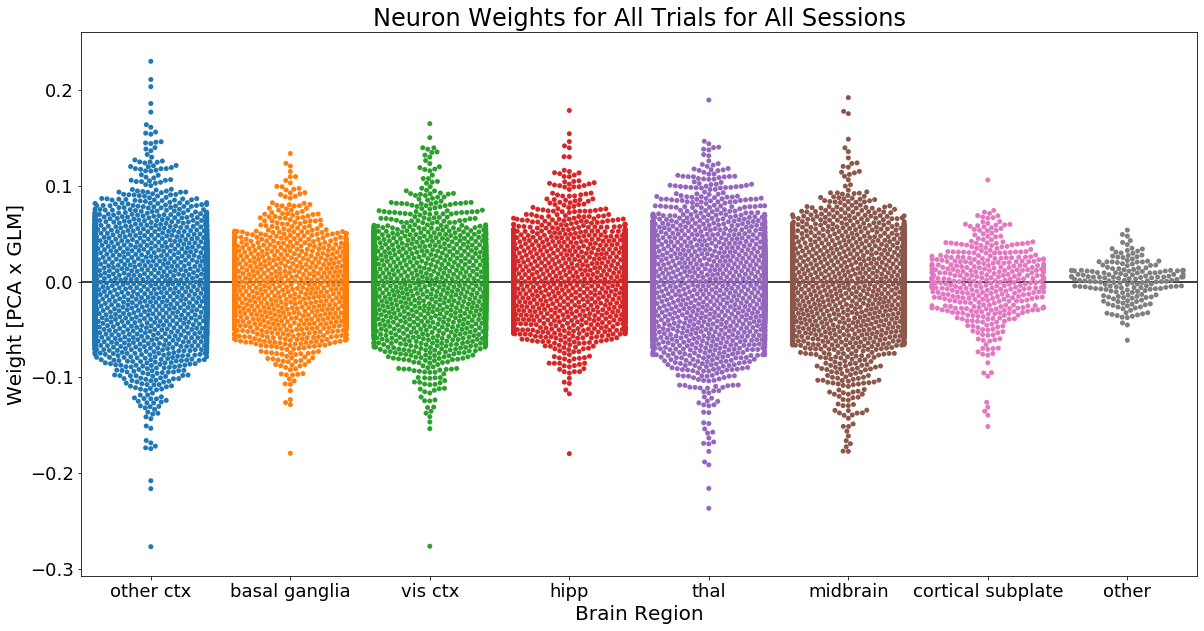

In [354]:
fig,ax = plt.subplots(1, 1, figsize=(20, 10))

#sns.violinplot(x='Brain Region',y='Coef',data=df_all,ax=ax,zorder=1,bw=1,scale='count',width=1,inner='point')
sns.swarmplot(x='Brain Region',y='Coef',data=df_all,ax=ax)
ax.set_title('Neuron Weights for All Trials for All Sessions',fontsize=24)
ax.tick_params(labelsize=18,direction = "out",top=False)
ax.set_xlabel('Brain Region',fontsize=20)
ax.set_ylabel('Weight [PCA x GLM]',fontsize=20)
ax.autoscale(False)
ax.hlines(0,-100,2000)


fig.savefig("model_all_accuracyfig.svg")




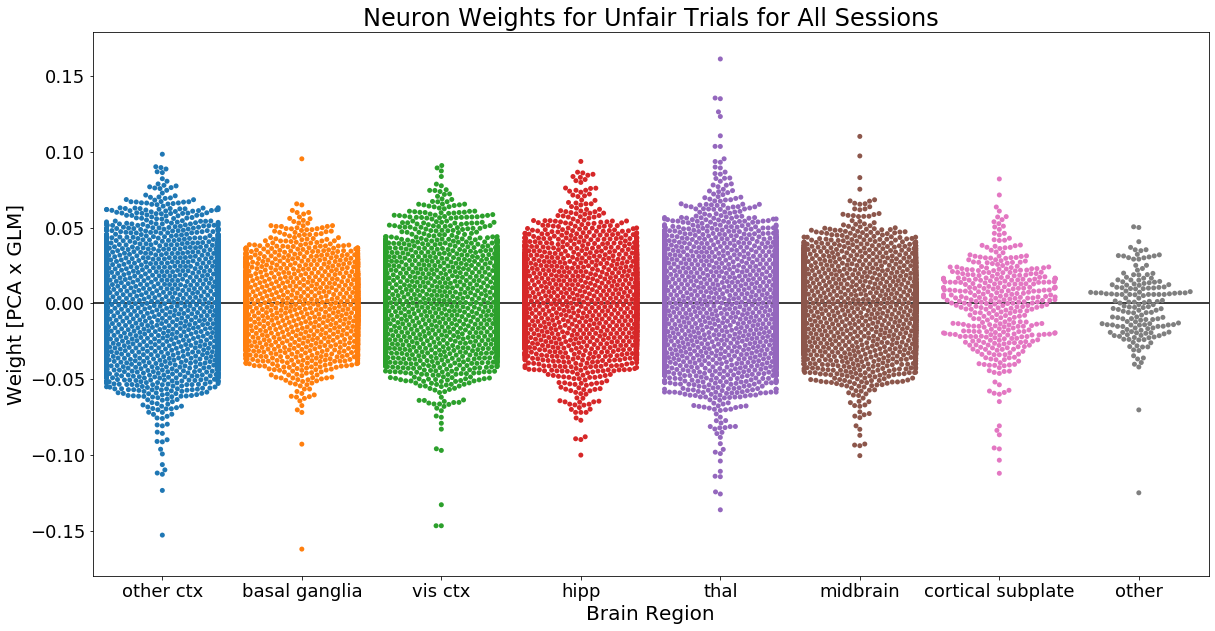

In [355]:
fig,ax = plt.subplots(1, 1, figsize=(20, 10))

sns.swarmplot(x='Brain Region',y='Coef',data=df_unfair,ax=ax)

ax.set_title('Neuron Weights for Unfair Trials for All Sessions',fontsize=24)
ax.tick_params(labelsize=18,direction = "out",top=False)
ax.set_xlabel('Brain Region',fontsize=20)
ax.set_ylabel('Weight [PCA x GLM]',fontsize=20)
ax.autoscale(False)
ax.hlines(0,-100,2000)

fig.savefig("model_unfair_accuracyfigs.svg")


In [299]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, .2, label, fontweight="bold", color="black",
            ha="left", va="center", transform=ax.transAxes)
    
ridge_plot = sns.FacetGrid(df_all, col="Brain Region", hue="Brain Region", aspect=1, height=50)
# Draw the densities in a few steps
ridge_plot.map(sns.kdeplot, "Coef",clip_on=False, shade=True, alpha=0.7,vertical=True)
ridge_plot.map(sns.distplot, "Coef",vertical=True)


#ridge_plot.map(label, "Coef")
# Set the subplots to overlap
ridge_plot.fig.subplots_adjust(hspace=-0.01)
# Remove axes details that don't play well with overlap
ridge_plot.set_titles("")
ridge_plot.set(yticks=[])

ridge_plot.despine(bottom=True, left=True)



AttributeError: 'FacetGrid' object has no attribute 'set_xlabel'

# Filter, PCA, and Model all sessions (with neurons)

In [ ]:
allb = ['ACA','ACB','APN', 'AUD', 'BLA', 'BMA', 'CA', 'CA1', 'CA2', 'CA3', 'CL', 'COA',
 'CP','DG','DP','EP','EPd','GPe','IC' ,'ILA', 'LD', 'LGd' ,'LH', 'LP', 'LS',
 'LSc','LSr','MB','MD','MEA','MG','MOp','MOs','MRN','MS','NB','OLF','ORB',
 'ORBm','OT','PAG','PIR','PL','PO','POL','POST','PT','RN','RSP','RT',
 'SCig','SCm','SCs','SCsg','SI','SNr','SPF','SSp','SSs','SUB','TH','TT',
 'VAL','VISa','VISam','VISl','VISp','VISpm','VISrl','VPL','VPM','ZI']

brain_areas = ['MOs']
brain_areas = allb

for session in range(len(alldat)):
    if np.sum(np.isin(alldat[session]['brain_area'],brain_areas))>0:
        filtered = filter_spikes(alldat,session,unfair_only=True,chosey_only=True, nonzero_only=True,brain_area=brain_areas)
        #filtered = rebin(filtered, 50, 250, 2)
        dat = neurons_PCA(filtered,0.9,0,250)
      # $ dat['PCs'] = dat['PCs'][0:dat['PCrange'],:]
        lambda_L2 = 1
        penalty = "none"
        l1args = {}
        left_bias = np.mean((filtered['chcs'])==1)
        choice_bias = [left_bias if left_bias > .5 else (1.0-left_bias)]
        w = {-1:left_bias, 1:(1-left_bias)}
       # l1args = {'solver':"saga", 'max_iter':5000}
        logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args)
        splitter = LeaveOneOut()
        splits = splitter.split(dat['PCs'].T)
        accuracies=[]
        predictions = []
        probs = []
        for fit_trials,test_trial in splits:
            logreg.fit((dat['PCs'][:,fit_trials]).T, dat['chcs'][fit_trials])
            prediction = logreg.predict(dat['PCs'][:,test_trial].T)[0]
            prob = logreg.predict_proba(dat['PCs'][:,test_trial].T)[0]
            actual = dat['chcs'][test_trial][0]
            accuracy = int(actual == prediction)
            predictions.append(prediction)
            accuracies.append(accuracy)
            probs.append(prob)   
        probs = np.array(probs)
        accuracies = np.array(accuracies)
        
        aob = accuracies.mean() - choice_bias
        print("Session# "+ str(session)+" accuracy = "+str(accuracies.mean())+" accuracy over bias = "+str(accuracies.mean() - choice_bias) + ", trial count= "+ str(len(accuracies)),"PC count= "+ str(dat['PCs'].shape[0]))

# Filter, PCA, and Model w/ different time bins

In [ ]:
binl = 25
bins = [x for x in range(0,250,binl)]
brain_areas = ["MOp"]

for bin in bins:
    session = 10
    filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
    dat = neurons_PCA(filtered,0.9,bin,bin+binl)
    lambda_L2 = 1
    penalty = "l2"
    l1args = {}
    logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args).fit(dat['PCs'].T, filtered['chcs'])
    splitter = LeaveOneOut()
    splits = splitter.split(dat['PCs'].T)
    accuracies = cross_val_score(logreg,dat['PCs'].T, filtered['chcs'], cv=splits, verbose=0) # k=8 crossvalidation
    print("Bin "+str(bin)+" to "+str(bin+binl)+" accuracy mean= "+str(accuracies.mean())+ ", percent left "+ str(np.mean((filtered['chcs'])==-1)))

In [ ]:
[(session,np.sum(np.isin(alldat[session]['brain_area'],["VISam", "VISl", "VISp", "VISpm", "VISrl"])), np.sum(np.isin(alldat[session]['brain_area'],["ACB","CP"]))) for session in range(len(alldat))]

In [ ]:
aba = []
for session in alldat:
    for ba in session['brain_area']:
        if ba not in aba:
            aba.append(ba)
            
print(np.sort(aba))

In [ ]:
lams = np.logspace(-4,4,num=9)
aobs = []
accs = []
for lam in lams:
    session = 10
    filtered = filter_spikes(alldat,session,unfair_only=True,chosey_only=True, nonzero_only=True,brain_area=brain_areas)
    dat = neurons_PCA(filtered,0.9,0,250)
    lambda_L2 = lam
    penalty = "l2"
    l1args = {}
    logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args).fit(dat['PCs'].T, filtered['chcs'])
    splitter = LeaveOneOut()
    splits = splitter.split(dat['PCs'].T)
    accuracies = cross_val_score(logreg,dat['PCs'].T, filtered['chcs'], cv=splits, verbose=0) # k=8 crossvalidation
    left_bias = np.mean((filtered['chcs'])==-1)
    choice_bias = [left_bias if left_bias > .5 else (1.0-left_bias)]
    aob = accuracies.mean() - choice_bias
    aobs.append(aob)
    accs.append(accuracies.mean())
plt.plot(np.log(lams),aobs)
plt.plot(np.log(lams),accs)

Session# 0 accuracy = 0.8857142857142857 bias= [0.5071428571428571], trial count= 140 PC count= 20 Bias accuracy:0.5071428571428571
Session# 1 accuracy = 0.821656050955414 bias= [0.5222929936305732], trial count= 157 PC count= 28 Bias accuracy:0.5222929936305732
Session# 2 accuracy = 0.8013245033112583 bias= [0.6225165562913908], trial count= 151 PC count= 25 Bias accuracy:0.6225165562913907
Session# 3 accuracy = 0.8699186991869918 bias= [0.5853658536585367], trial count= 123 PC count= 25 Bias accuracy:0.5853658536585366
Session# 4 accuracy = 0.8133333333333334 bias= [0.6466666666666667], trial count= 150 PC count= 29 Bias accuracy:0.6466666666666666
Session# 5 accuracy = 0.8080808080808081 bias= [0.5707070707070707], trial count= 198 PC count= 38 Bias accuracy:0.5707070707070707
Session# 6 accuracy = 0.8578947368421053 bias= [0.6105263157894737], trial count= 190 PC count= 27 Bias accuracy:0.6105263157894737
Session# 7 accuracy = 0.9299363057324841 bias= [0.6305732484076433], trial co

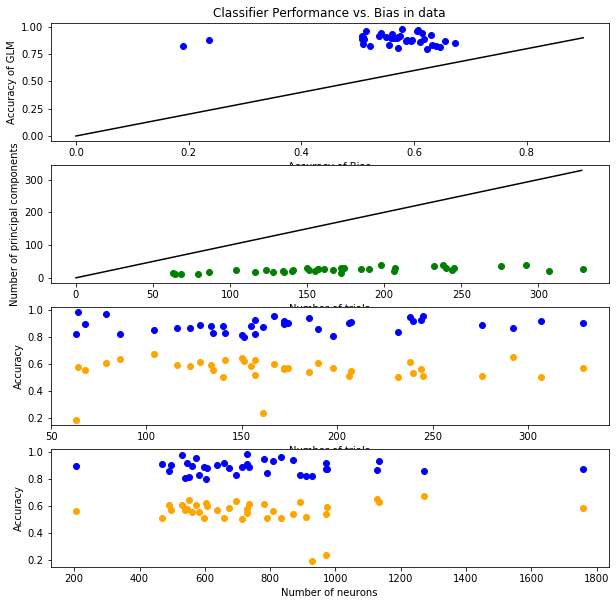

In [51]:
from model_tester import test_model
allb = ['ACA','ACB','APN', 'AUD', 'BLA', 'BMA', 'CA', 'CA1', 'CA2', 'CA3', 'CL', 'COA',
 'CP','DG','DP','EP','EPd','GPe','IC' ,'ILA', 'LD', 'LGd' ,'LH', 'LP', 'LS',
 'LSc','LSr','MB','MD','MEA','MG','MOp','MOs','MRN','MS','NB','OLF','ORB',
 'ORBm','OT','PAG','PIR','PL','PO','POL','POST','PT','RN','RSP','RT',
 'SCig','SCm','SCs','SCsg','SI','SNr','SPF','SSp','SSs','SUB','TH','TT',
 'VAL','VISa','VISam','VISl','VISp','VISpm','VISrl','VPL','VPM','ZI']


regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]



sessions = [*range(0,37)]
l2=1000000000000

#output = test_model(alldat,sessions=sessions,brain_areas=allb,unfair_only=True,chosey_only=True,nonzero_only=True,penalty_type='none',toweight=False,verbose=True)

output = test_model(alldat,sessions=sessions,brain_areas=allb,unfair_only=False,chosey_only=True,nonzero_only=False)

plot_results(output)

In [46]:
output = test_model(alldat,sessions=sessions,brain_areas=allb,unfair_only=True,chosey_only=True,nonzero_only=True)
plot_results(output)

Session# 0 accuracy = 0.4 bias= [0.8], trial count= 10 PC count= 3 Bias accuracy:0.8


AttributeError: 'dict' object has no attribute 'shape'

In [ ]:
plot_session(alldat, 38, select_areas = None, unfair_only=True,chosey_only=True,nonzero_only=True)

In [181]:
lambdas = np.logspace(-3,3,20)

outputs_alltrials = [test_model(alldat,sessions=[*range(37)],brain_areas=allb,unfair_only=False,chosey_only=True,nonzero_only=False,Cpen=x,penalty_type='l2',toweight=False,verbose=False) for x in lambdas]
print('done')



done


In [183]:
outputs_onlyunfair = [test_model(alldat,sessions=[*range(37)],brain_areas=allb,unfair_only=True,chosey_only=True,nonzero_only=True,Cpen=x,penalty_type='l2',toweight=False,verbose=False) for x in lambdas]
print('done')

done


In [195]:
from scipy.stats import sem


testl2s_all_samp = np.array([(lam,(output['Accuracies'])[0]) for lam,output in zip(lambdas,outputs_alltrials)])

testl2s_all_mean = np.array([(lam,np.mean(output['Accuracies'])) for lam,output in zip(lambdas,outputs_alltrials)])
testl2s_all_std = np.array([(lam,sem(output['Accuracies'])) for lam,output in zip(lambdas,outputs_alltrials)])
testl2s_unfair_sample = np.array([(lam,(output['Accuracies'])[0]) for lam,output in zip(lambdas,outputs_onlyunfair)])

testl2s_unfair_mean = np.array([(lam,np.mean(output['Accuracies'])) for lam,output in zip(lambdas,outputs_onlyunfair)])
testl2s_unfair_std = np.array([(lam,sem(output['Accuracies'])) for lam,output in zip(lambdas,outputs_onlyunfair)])
print('done')

done


Regularization Figure

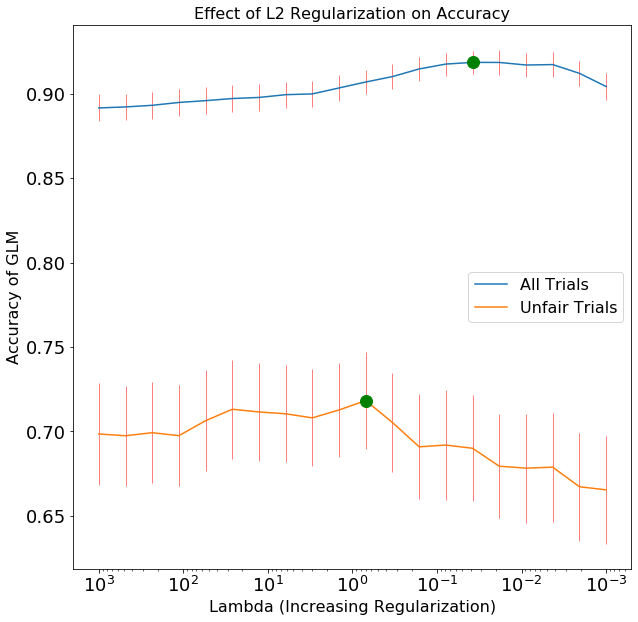

In [323]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot((testl2s_all_mean[:,0]),testl2s_all_mean[:,1],label='All Trials')


ax.errorbar((testl2s_all_std[:,0]),testl2s_all_mean[:,1],yerr=testl2s_all_std[:,1],fmt='none',color='red',elinewidth=.5)

ax.plot((testl2s_unfair_mean[:,0]),testl2s_unfair_mean[:,1],label='Unfair Trials')
ax.errorbar((testl2s_unfair_std[:,0]),testl2s_unfair_mean[:,1],yerr=testl2s_unfair_std[:,1],fmt='none',color='red',elinewidth=.5)


ax.set_xlabel("Lambda (Increasing Regularization)",fontsize=16)
ax.set_ylabel("Accuracy of GLM",fontsize=16)
ax.set_title("Effect of L2 Regularization on Accuracy",fontsize=16)
ax.set_xscale('log',basex=10)
ax.set_xlim(ax.get_xlim()[1],ax.get_xlim()[0])


all_trial_maxl = np.where(testl2s_all_mean[:,1]==np.max(testl2s_all_mean[:,1]))[0][0]
all_trial_max = testl2s_all_mean[all_trial_maxl,0]
unfair_trial_maxl = np.where(testl2s_unfair_mean[:,1]==np.max(testl2s_unfair_mean[:,1]))[0][0]
unfair_trial_max = testl2s_unfair_mean[unfair_trial_maxl,0]


ax.plot(all_trial_max,np.max(testl2s_all_mean[:,1]),marker='o',color='green',markersize=12,zorder=10)
ax.plot(unfair_trial_max,np.max(testl2s_unfair_mean[:,1]),marker='o',color='green',markersize=12,zorder=10)


(all_trial_max,unfair_trial_max)

plt.savefig("l2regularization_fig.svg")

ax.tick_params(labelsize=18,direction = "out",top=False)
ax.legend(fontsize=16,loc='center right')

# Plot Bias/Accuracy

In [203]:
from model_tester import test_model



output_all_trials = test_model(alldat,sessions=[*range(0,37)],brain_areas=allb,unfair_only=False,chosey_only=True,nonzero_only=False,
                               penalty_type='l2',Cpen=all_trial_max,
                               verbose=False)

output_only_unfair = test_model(alldat,sessions=[*range(0,37)],brain_areas=allb,unfair_only=True,chosey_only=True,nonzero_only=True,
                                penalty_type='l2',Cpen=unfair_trial_max,
                                verbose=False)

print('done')

done


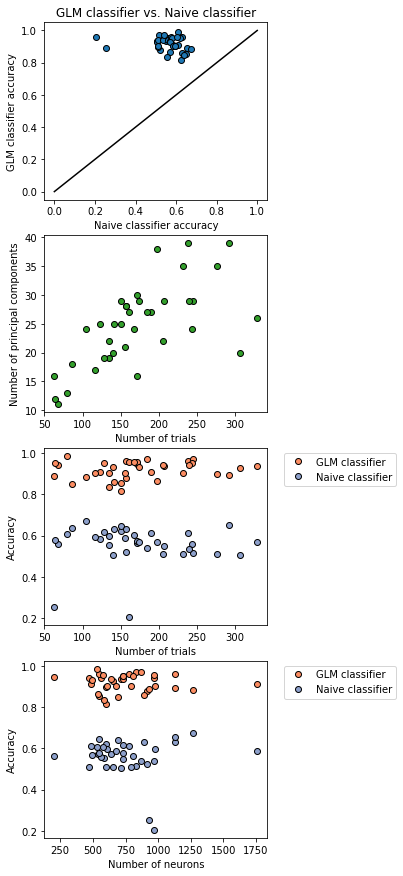

In [209]:
plot_results(output_all_trials)
plt.savefig("model_accuracyfigs_alltrials.svg")

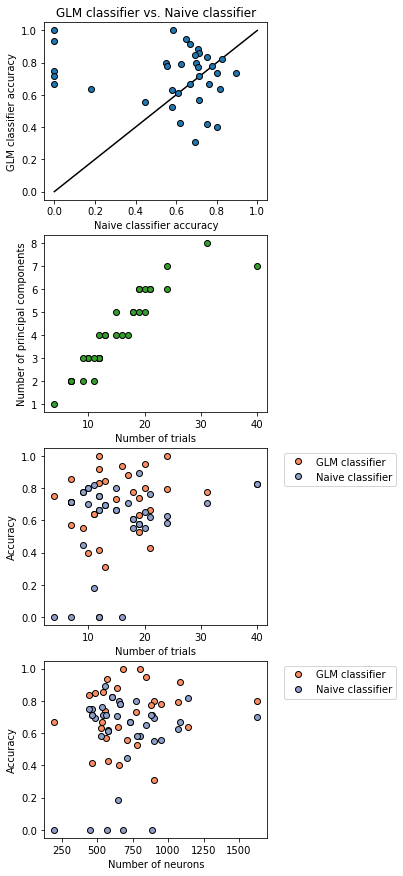

In [210]:
plot_results(output_only_unfair)
plt.savefig("model_accuracyfigs_unfairtrials.svg")